# HW6: Variational Autoencoders


**STATS271/371: Applied Bayesian Statistics**

_Stanford University. Spring, 2021._

---

**Name:** Isaac Kleisle-Murphy

**Names of any collaborators:** N/A

No in class collaborators. However, to learn the mechanics of Tensorflow and Keras, I scoured the internet and read through a number of VAE implementations. I then combined what I learned from each/took the good parts of each. The articles I read included:

- https://www.tensorflow.org/tutorials/generative/cvae

- https://keras.io/examples/generative/vae/

- https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_VAE.ipynb

- https://learnopencv.com/variational-autoencoder-in-tensorflow/

- https://towardsdatascience.com/6-different-ways-of-implementing-vae-with-tensorflow-2-and-tensorflow-probability-9fe34a8ab981


*Due: 11:59pm Monday, May 17, 2021 via GradeScope*

---

Our goal is to learn the parameters $\Theta$ of a distribution over data, $p(x_n \mid \Theta)$. We assume a latent variable model of the following form:
$$
p(x_n \mid \Theta) = \int p(x_n \mid z_n, \Theta) \, p(z_n) \mathrm{d} z_n
$$
The prior $p(z_n)$ can be very simple (e.g. a standard Gaussian distribution) as long as the likelihood, $p(x_n \mid z_n, \Theta)$, is sufficiently flexible. Then the latent variable model can capture very complex data distributions.

Variational autoencoders (VAEs) are one way of training latent variable models like the one above. We'll build a very simple VAE in this homework assignment and apply it to a standard image dataset, the MNIST dataset of handwritten digits.

Assume the following functional forms for the latent variable model above,
\begin{align}
p(z_n) &= \mathcal{N}(z_n \mid 0, I) \\
p(x_n \mid z_n, \Theta) &= \mathcal{N}(f(z_n, w), \Sigma)
\end{align}
where $f$ is a nonlinear mapping from latent variables $z$ to expected observations $\mathbb{E}[x_n \mid z_n] = f(z_n, w)$. The full set of generative model parameters are $\Theta = (w, \Sigma)$. 

We'll use variational expectation-maximization (vEM) to learn the model parameters. This entails an inner inference step (the variational E-step) to approximate the posterior
\begin{align}
q(z_n; \lambda_n) &\approx p(z_n \mid x_n, \Theta).
\end{align}
Optimizing these variational parameters $\lambda_n$ for each data point can be very time consuming, involving many iterations of gradient ascent for each variational E-step.

The key insight of VAEs is that our time might be better spent optimizing the model parameters instead, and that we can get by with a worse approximation to the posterior if it allows us more updates of $\Theta$. To that end, VAEs simultaneously train an *inference network* to quickly map data points $x_n$ to variational parameters $\lambda_n$. Concretely, VAEs learn a function,
\begin{align}
\lambda_n &= g(x_n; \phi),
\end{align}
The variational parameters $\phi$ are shared by all datapoints, thereby *amortizing* the cost of inference across examples. Under this formulation, we will simply write,
\begin{align}
q(z_n; \lambda_n) &= q(z_n; g(x_n; \phi)) \triangleq q(z_n; x_n, \phi).
\end{align}

To train a variational autoencoder, we perform stochastic gradient ascent on the ELBO $\mathcal{L}(\Theta, \phi)$ with respect to both $\Theta$ and $\phi$ using Monte Carlo estimates of the gradient.

## Problem 1: Math

Consider a dataset $\{x_n\}_{n=1}^N$ with $x_n \in \mathbb{R}^D$ and assume continuous latent variables $z_n \in \mathbb{R}^P$ with a standard normal prior. We'll assume a variational approximation to the posterior on $z_n \in \mathbb{R}^P$ of the form,
\begin{align}
q(z_n; x_n, \phi) &= \mathcal{N}(z_n; \mu_n, \mathrm{diag}(\sigma_n^2)),
\end{align}
where $\mu_n \in \mathbb{R}^P$ and $\sigma_n^2 \in \mathbb{R}_+^P$ are the variational parameters output by the inference network $g(x_n; \phi)$.

### Problem 1a: Write a Monte Carlo estimator for the ELBO 
Use random mini-batches of data to write a Monte Carlo estimate of the ELBO,
\begin{align}
\mathcal{L}(\Theta, \phi) &\approx \ldots
\end{align}.

We'll show this answer for a single observation $n$; the full result follows then from summing $n=1, \ldots, N$. 

First, we expand for $\theta = (w, \Sigma)$:

\begin{align*}
\mathcal{L}(q; \theta, \rho)
&=
E_q[\log p(\vec x, \vec z | \theta) - \log q(\vec z; \vec x, \phi) + \log p(\theta)] \\
&=
E_{\vec q} \bigg[\sum_{n=1}^N \log p(x_n | z_n, \theta) + \log p(z_n) - \log q(z_n; x_n, \phi)\bigg] + \log p(\theta) \\
&=
\frac{N}{N}\bigg[\sum_{n=1}^N E_{q_n}\log p(x_n | z_n, \theta)  - D_{KL}(q(z_n; x_n, \phi) || p(z_n))\bigg] + \log p(\theta) \\
&=
\frac{N}{N}\bigg[\sum_{n=1}^N E_{q_n}\log \{N(x_n | f(z_n, w), \Sigma)\}  - D_{KL}(q(z_n; x_n, \phi) || p(z_n))\bigg] + \log p(\theta) \\
&\approx
\frac{N}{N}\bigg[\sum_{n=1}^N E_{q_n}\log \{N(x_n | f(z_n, w), \sigma^2 I)\}  - D_{KL}(q(z_n; x_n, \phi) || p(z_n))\bigg] + \log p(\theta) \\
&=
\frac{N}{N} \sum_{n=1}^N\mathcal{L}_n(q_n; \theta, \phi) + \log p(\theta).
\end{align*}
If $N$ is large or computation is expensive, we might just take a random subset of the data here -- i.e. a ``minibatch'' -- and use that as an estimate. 



### Problem 1b: Write a Monte Carlo estimate of the gradient wrt $\Theta$
Use random mini-batches of data to write a Monte Carlo estimate of the gradient,
\begin{align}
\nabla_\Theta \mathcal{L}(\Theta, \phi) &\approx \ldots
\end{align}

Accordingly, we have (block-matrix style):
\begin{align*}
\nabla_\theta \mathcal{L}_n(q_n; \theta, \phi)
&=
\begin{bmatrix}
\nabla_w \mathcal{L}_n(q_n; \theta, \phi) \\
\nabla_{\sigma^2} \mathcal{L}_n(q_n; \theta, \phi)
\end{bmatrix}\\
&=
\begin{bmatrix}
\nabla_w \log \exp(-\frac{(x_n - f(z_n, w))^2}{2\sigma^2}) \\
\nabla_{\sigma^2} \log (1/(\sqrt{2\pi}\sigma)) + \log \exp(-\frac{(x_n - f(z_n, w))^2}{2\sigma^2})
\end{bmatrix}\\
&=
\begin{bmatrix}
(x_n - f(z_n, w))\nabla_w f(z_n,w) \\
-1/\sigma + \sigma^{-3} (x_n - f(z_n, w))^2
\end{bmatrix}.
\end{align*}

Of course, the algebraic sequence above omitted the $\nabla_\theta p(\theta)$ term for the prior -- however, given its omission/lack of specification in the problem, we assume that $$
p(\theta)\propto 1 \implies \nabla_\theta p(\theta) = 0. 
$$

We can then use Monte Carlo to approximate the above. That is, for each $n$, we could draw $\ell$ realizations from $q(z_n, \lambda_n)$, compute the corresponding $\nabla_\theta \mathcal{L}_n$'s for those draws, average them, and then sum across observations $n$. If there are many observations, we would likely do this batch-wise -- i.e. perform this procedure on some random subset of the data, encouraging fewer computations and faster runtimes. 


### Problem 1c: Derive the KL divergence between two Gaussians
Derive the KL divergence between two multivariate normal distributions,
\begin{align}
\mathrm{KL}\big(\mathcal{N}(\mu_1, \Sigma_1) \, \| \, \mathcal{N}(\mu_2, \Sigma_2) \big) &= 
\end{align}

Let
$$
q \sim N(\mu_1, \Sigma_1)
$$
and 
$$
p \sim N(\mu_2, \Sigma_2).
$$
We have
\begin{align*}
D_{KL}(q||p)
&=
E_q [\log q - log p]\\
&=
E_q\bigg[
.5 (\log |\Sigma_2| - \log |\Sigma_1| - (x - \mu_1)^T\Sigma_1^{-1}(x - \mu_1) + (x - \mu_2)^T\Sigma_2^{-1}(x - \mu_2)
\bigg] \\
&=
\frac{1}{2} E_q [
\log (|\Sigma_2| / |\Sigma_1|)]
-\frac{1}{2} E_q[(x - \mu_1)^T\Sigma_1^{-1}(x - \mu_1) ] +
\frac{1}{2} E_q[(x - \mu_2)^T\Sigma_2^{-1}(x - \mu_2) ] \\
&=
\frac{1}{2} 
\log (|\Sigma_2| / |\Sigma_1|)
-\frac{1}{2} E_q[tr\{(x - \mu_1)^T\Sigma_1^{-1}(x - \mu_1) \}] +
\frac{1}{2} E_q[tr\{(x - \mu_2)^T\Sigma_2^{-1}(x - \mu_2) \}] \\
&=
\frac{1}{2} 
\log (|\Sigma_2| / |\Sigma_1|)
-\frac{1}{2} E_q[tr\{(x - \mu_1)(x - \mu_1)^T\Sigma_1^{-1} \}] +
\frac{1}{2} E_q[tr\{(x - \mu_2)(x - \mu_2)^T\Sigma_2^{-1} \}] \\
&=
\frac{1}{2} 
\log (|\Sigma_2| / |\Sigma_1|)
-\frac{1}{2} E_q[tr\{(x - \mu_1)(x - \mu_1)^T\Sigma_1^{-1} \}] +
\frac{1}{2} E_q[tr\{(x - \mu_2)(x - \mu_2)^T\Sigma_2^{-1} \}] \\
&=
\frac{1}{2} 
\log (|\Sigma_2| / |\Sigma_1|)
-\frac{1}{2} tr\{E_q[(x - \mu_1)(x - \mu_1)^T\Sigma_1^{-1}] \}+
\frac{1}{2} tr\{E_q[(x - \mu_2)(x - \mu_2)^T\Sigma_2^{-1}] \}\\
&=
\frac{1}{2} 
\log (|\Sigma_2| / |\Sigma_1|)
-\frac{1}{2} tr\{E_q[\Sigma_1\Sigma_1^{-1}] \}+
\frac{1}{2} tr\{E_q[(x - \mu_2)(x - \mu_2)^T\Sigma_2^{-1}] \}\\
&=
\frac{1}{2} 
\log (|\Sigma_2| / |\Sigma_1|)
-\frac{1}{2} tr\{I_P \}]+
\frac{1}{2} tr\{E_q[(x - \mu_2)(x - \mu_2)^T\Sigma_2^{-1}] \}\\
&=
\frac{1}{2} 
\log (|\Sigma_2| / |\Sigma_1|)
-\frac{1}{2} P+
\frac{1}{2} tr\{
\underbrace{E_q[(x - \mu_2)(x - \mu_2)^T\Sigma_2^{-1}] }_{(\mu_1 - \mu_2)^T\Sigma_2^{-1}(\mu_1 - \mu_2) + tr\{\Sigma_2^{-1}\Sigma_1\}}\
\\
&=
\frac{1}{2} 
\log (|\Sigma_2| / |\Sigma_1|)
-\frac{1}{2} P+
\frac{1}{2} (\mu_1 - \mu_2)^T\Sigma_2^{-1}(\mu_1 - \mu_2) + tr\{\Sigma_2^{-1}\Sigma_1\}.
\end{align*}

We'll see this in our Tensorflow implementation in section 2. 

### Problem 1d: Write a Monte Carlo estimate of the gradient wrt $\phi$
Use reparameterization gradients and random mini-batches of data to write a Monte Carlo estimate of the gradient,
\begin{align}
\nabla_\phi \mathcal{L}(\Theta, \phi) &\approx \ldots
\end{align}


\subsection{d}
Let's first work at the $n$ level again. Recall, from P1,
\begin{align*}
\mathcal{L}_n(q_n; \theta, \phi)
&=
E_{q_n}\log \{N(x_n | f(z_n, w), \sigma^2 I)\}  - D_{KL}(q(z_n; x_n, \phi) || p(z_n))
\end{align*}
Since we know the closed form for the KL term, we'll return to that later. Let's instead focus on
$$
E_{q_n}\log \{N(x_n | f(z_n, w), \sigma^2 I)\}.
$$
Applying the reparameterization trick gives:
\begin{align*}
E_{q_n}\log \{N(x_n | f(z_n, w), \sigma^2 I)\}
&=
E_{\epsilon_n \sim N(0, I)}[\log \{p(x_n | f[g_{\mu}(x_n, \phi) + \epsilon_ng_{\tau}(x_n, \phi)^{1/2}, w], \sigma^2 I)\}],
\end{align*}
where $g_{\mu}$ is the part of encoder $g$ that maps to the variational means (i.e. the subset of the output intended to be the mean) and $g_\tau$ is the part of $g$ that maps to the variational covariances (we use $\tau$ since $\sigma$ was taken to diagonalize $\Sigma$, lest there be confusion). Hence,
$$
\nabla_\phi E_{q_n}\log \{N(x_n | f(z_n, w), \sigma^2 I)\}
$$
$$
=
$$
$$
E_{\epsilon_n \sim N(0, I)}[\nabla_\phi \log \{p(x_n | f\bigg(g_{\mu}(x_n, \phi) + \epsilon_ng_{\tau}(x_n, \phi)^{1/2}, w\bigg), \sigma^2 I)\}],
$$
which requires a chain rule over both the encoder and decoder to compute. Returning to the KL divergence, we have from 3 that (if we assume diagonal covariance for our latent parameters)
\begin{align*}
\nabla_\theta D_{KL}(q(z_n; x_n, \phi) || p(z_n)) 
&=
\nabla_\phi \frac{1}{2}\bigg[g_{\mu}(x_n, \phi)^T g_{\mu}(x_n, \phi) - tr \{g_{\tau}(x_n, \phi)\} - P -\log |g_{\tau}(x_n, \phi)| \bigg]\\
&=
g_{\mu}(x_n, \phi) \nabla_\phi g_{\mu}(x_n, \phi) - \nabla_\phi tr \{g_{\tau}(x_n, \phi)\}/2 - (2g_{\tau}(x_n, \phi))^{-1}. 
\end{align*}
In all, this gives
\begin{align*}
\nabla_\phi \mathcal{L}_n(q_n ; \theta, \phi)
&=
E_{\epsilon_n \sim N(0, I)}[\nabla_\phi \log \{p(x_n | f\bigg(g_{\mu}(x_n, \phi) + \epsilon_ng_{\tau}(x_n, \phi)^{1/2}, w\bigg), \sigma^2 I) - \\
&\;\;\;
g_{\mu}(x_n, \phi) \nabla_\phi g_{\mu}(x_n, \phi) - \nabla_\phi tr \{g_{\tau}(x_n, \phi)\}/2 - (2g_{\tau}(x_n, \phi))^{-1}. 
\end{align*}
Hence, for the full gradient, we would have to sum over the $N$ observations (above is just a single observation $n$). The first term can be achieved via MC samples of $\epsilon_n$, and then averaging in a manner similar to that outlined in P2; meanwhile, the second term can be calculated explicitly (corresponding to each MC draw). 

## Problem 2: Code
In this problem, you will implement a simple VAE model and train it on the MNIST handwritten digits dataset. The inputs 28x28 pixel images, which are flattened to into vectors of dimension $D=784$.  Let both $p(x_n \mid z_n, \Theta)$ and $q(z_n ; x_n, \phi)$ be parametrized by neural networks with one hidden layer that consists of $512$ ReLU neurons and let the dimensionality of the latent space be $P=2$. The weight matrices between the layers should be initialized randomly by sampling from $\mathcal{N}(0, 0.01)$ and the biases should be initially set to zeros. Since the $x_n$'s are continuous but standardized to lie in $[0,1]$, the output layer of the generative network $f(z_n, w)$ should have sigmoidal nonlinearities.

The variational distribution, $q(z_n; x_n, \phi)$, is a diagonal Gaussian distribution, as in Problem 1. The inference network should output a mean vector and a *non-negative* vector of variances for each latent dimension.

### Problem 2a: Build the VAE
Build the VAE described above. There's no "right" way to organize your code, and different deep learning frameworks encourage different types of implementations. In Python, I like to use classes to encapsulate the parameters of the generative and inference networks (i.e. $\Theta$ and $\phi$). The class would expose automatically differentiable functions like `infer`, `generate`, and `compute_elbo` to map data points to posterior parameters, compute the mean of the image given a latent sample, and evaluate a Monte Carlo estimate of the ELBO for a mini-batch of data, respectively. Then you can use stochastic gradient ascent to maximize the ELBO with respect to the parameters.

#### Note on implementation:
- You are free to use any programming language for your implementation.
- We recommend you additionally use a library with support that allows you to perform automatic reverse-mode differentiation which will simplify model development. Both TensorFlow or PyTorch, e.g., have implemented distributions that make it easy to implement reparameterization gradients.
- You are *not* allowed to use any libraries that provide some sort of pre-made implementations of the variational autoencoders. That is, one line implementations like `vae = VAE(...)` are not in the spirit of this assignment.
- For the optimization, we recommend you use one of the popular algorithms such as Adagrad [1] or Adam [2].


#### Note on the Honor Code:
- There are many examples freely available on the internet of similar implementations. If you follow any such sources, you must clearly cite them in your submission. 
- You need to implement the models and the training algorithms using standard libraries (including TensorFlow, PyTorch, Keras, etc.) yourself.

#### References
- [1] John Duchi, Elad Hazan, and Yoram Singer. Adaptive subgradient methods for online learning and stochastic optimization. Journal of Machine Learning Research, 12(Jul):2121–2159, 2011.
- [2] Diederik Kingma and Jimmy Ba. Adam: A method for stochastic optimization. arXiv preprint arXiv:1412.6980, 2014.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, initializers
from tensorflow import keras
from tensorflow.keras import backend as K
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255.
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255.

_IMG_DIM = (28, 28, 1) # np.prod(x_train.shape[1:3])
_P = 2

def kldiv(mu, log_sigma2):
    # see problem: squared mean; trace, P, log||
    return -0.5 * K.sum(- K.square(mu) - K.exp(log_sigma2) + 1 + log_sigma2, axis = 1)

# note -- MSE has been producing much faster/more feasible runtimes, so subbing that in here
# furthermore, tensorflow tutorial recommends upweighting the loglik (here, approximated via MSE; see their implementation also)
# by a factor of 1000 -- for reproducability, we'll go with that
def loglik_approx(y, yhat):
    return 1000 * K.mean(K.square(y - yhat), axis = [1,2,3])

def compute_loss(y, yhat, mu, log_sigma2):
    return loglik_approx(y, yhat) + kldiv(mu, log_sigma2)

def reparameterize_and_mc_sample(normal_params, u0=0., sigma0=1.):
    mu, log_sigma_sq = normal_params
    return mu + K.exp(.5 * log_sigma_sq) * K.random_normal(shape=K.shape(mu), mean=u0, stddev=sigma0)

class VAE:
  """
  Class for a VAE
  """
  def __init__(self, eta=1e-3, p=_P, img_dim=_IMG_DIM):
    self.p = p
    self.img_dim = img_dim
    self.opt = tf.keras.optimizers.Adam(lr=eta)

  def construct_encoder(self):
    inputs = keras.Input(shape=self.img_dim)
    x = layers.Flatten()(inputs)
    x = layers.Dense(512)(x)
    x = layers.ReLU()(x)
    mu = layers.Dense(self.p, 
                      kernel_initializer=initializers.RandomNormal(stddev=0.01),
                      bias_initializer=initializers.Zeros())(x)
    log_sigma_sq = layers.Dense(self.p)(x)
    return tf.keras.Model(inputs, (mu, log_sigma_sq))

  def construct_decoder(self):
    inputs = keras.Input(shape=self.p)
    x = layers.Dense(512, 
                     kernel_initializer=initializers.RandomNormal(stddev=0.01),
                     bias_initializer=initializers.Zeros())(inputs)
    x = layers.ReLU()(x)
    outputs = layers.Dense(np.prod(self.img_dim), activation='sigmoid')(x)
    return tf.keras.Model(inputs, outputs)

  def construct_latent_normal(self):
    # build the normal params as inputs
    u_, log_sigma2_ = keras.Input(shape=self.p), keras.Input(shape=self.p)
    # take the inputs, do a monte carlo normal sample via the reparam trick
    draw_result = layers.Lambda(reparameterize_and_mc_sample)([u_, log_sigma2_])
    return tf.keras.Model([u_, log_sigma2_], draw_result)

  def construct(self):
    self.mod_encoder = self.construct_encoder()
    self.mod_decoder = self.construct_decoder()

  def reconstruct_and_get_loss(self, images, training=True):
    # pass through encoder
    mu_n, log_sigma_sq_n = self.mod_encoder(images, training=training)
    # initializer the z object
    z_object = self.construct_latent_normal()
    z = z_object([mu_n, log_sigma_sq_n])
    reconstructed_img_flat = self.mod_decoder(z,training=training)
    reconstructed_img = tf.reshape(reconstructed_img_flat, shape=(reconstructed_img_flat.shape[0],) + self.img_dim)
    pass_loss = compute_loss(images, reconstructed_img, mu_n, log_sigma_sq_n)
    return reconstructed_img, pass_loss

  def update(self, images, **kwargs):
    with tf.GradientTape() as e, tf.GradientTape() as d:
      rec_img, loss = self.reconstruct_and_get_loss(images, **kwargs)
    nabla_dec = d.gradient(loss, self.mod_decoder.trainable_variables)
    nabla_enc = e.gradient(loss, self.mod_encoder.trainable_variables)

    self.opt.apply_gradients(zip(nabla_dec, self.mod_decoder.trainable_variables))
    self.opt.apply_gradients(zip(nabla_enc, self.mod_encoder.trainable_variables))
    return loss

  def _fit(self, data,  n_iter=3, **kwargs):
    for _ in trange(n_iter):
      for batch in data:
        _ = self.update(images=batch, **kwargs)

  def fit(self, X, n_iter=10, batch_size=2056, **kwargs):
    data_ = tf.data.Dataset.from_tensor_slices(X).shuffle(X.shape[0]).batch(batch_size)
    self._fit(data=data_, n_iter=n_iter, **kwargs)

  def predict_encoder(self, X):
    return self.mod_encoder.predict(X)

  def predict_sample_z(self, X):
    mu, log_sigma2 = self.predict_encoder(X)
    z_object = self.construct_latent_normal()
    return z_object.predict([mu, log_sigma2])

  def predict_reconstruct(self, X):
    zhat = self.predict_sample_z(X)
    return self.mod_decoder.predict(zhat).reshape((X.shape[0], ) + self.img_dim)

11493376/11490434 [==============================] - 0s 0us/step


### Problem 2b: Train the VAE with stochastic gradient ascent on the ELBO

Train and evaluate your models on the MNIST handwritten digits dataset. The dataset can be downloaded directly from [here](http://yann.lecun.com/exdb/mnist/). Alternatively, many deep learning libraries have utilities to download the dataset into their desired format. (E.g. [PyTorch](https://pytorch.org/vision/stable/datasets.html#mnist), [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data), and [TensorFlow for R](https://tensorflow.rstudio.com/guide/keras/))


In [2]:
# initialise model
mod_vae = VAE(eta=.001)
mod_vae.construct()
# fit model
mod_vae.fit(x_train, n_iter=100)
# reconstruct on test set
x_test_rec =  mod_vae.predict_reconstruct(x_test)

100%|██████████| 100/100 [17:09<00:00, 10.29s/it]


## Problem 3: Analysis

### Problem 3a: Sample from the VAE
Visualize a random sample of $100$ MNIST digits on $10 \times 10$ tile grid (i.e., $10$ rows, $10$ digits per row).
Using your trained models, sample and visualize $100$ digits from each of them in the same manner. To do this, sample $100$ random $z$, then apply the generator network, $p(x_n \mid z_n)$, to produce digit samples. Comment on the results.

First, the true images:

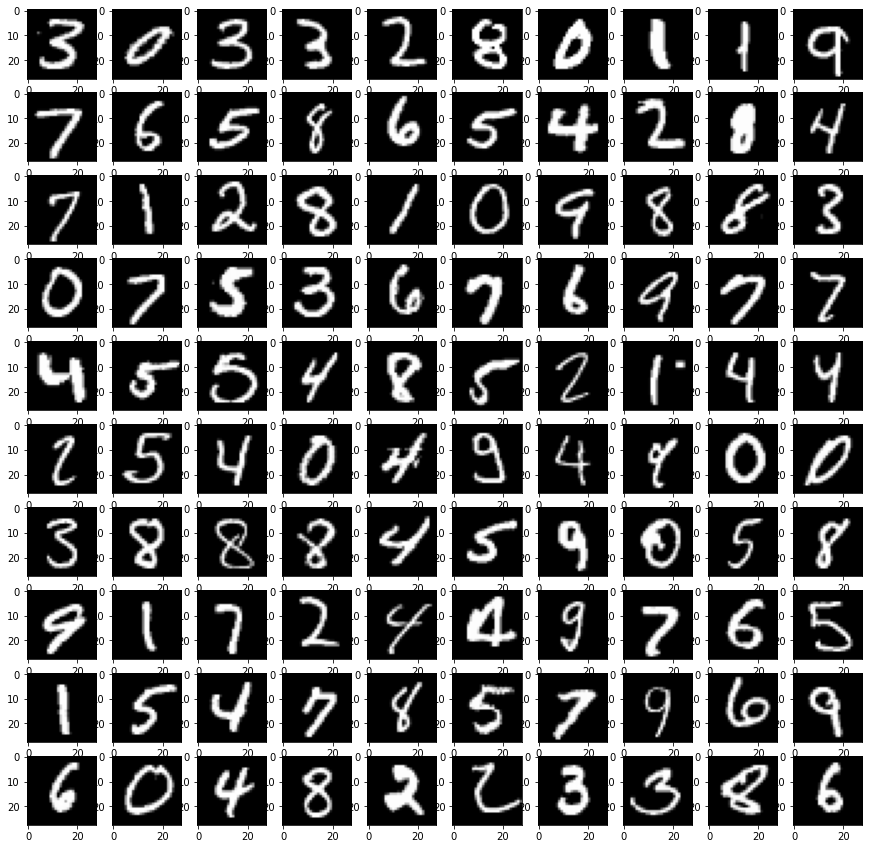

In [3]:
np.random.seed(2020)
slc = np.random.choice(range(x_test_rec.shape[0]), 100)
q3a_draws = x_test_rec[slc, :, :, :]
q3a_true = x_test[slc, :, :, :]


fig, axs = plt.subplots(10, 10, figsize=(15,15))
col_ctr, row_ctr = 0, 0
for i in range(100):
  axs[row_ctr, col_ctr].imshow(q3a_true[i, :, :, 0] * 255, cmap='gray')
  col_ctr += 1
  if col_ctr == 10:
    row_ctr += 1
    col_ctr = 0

Second, the reconstructed version of the above true images:

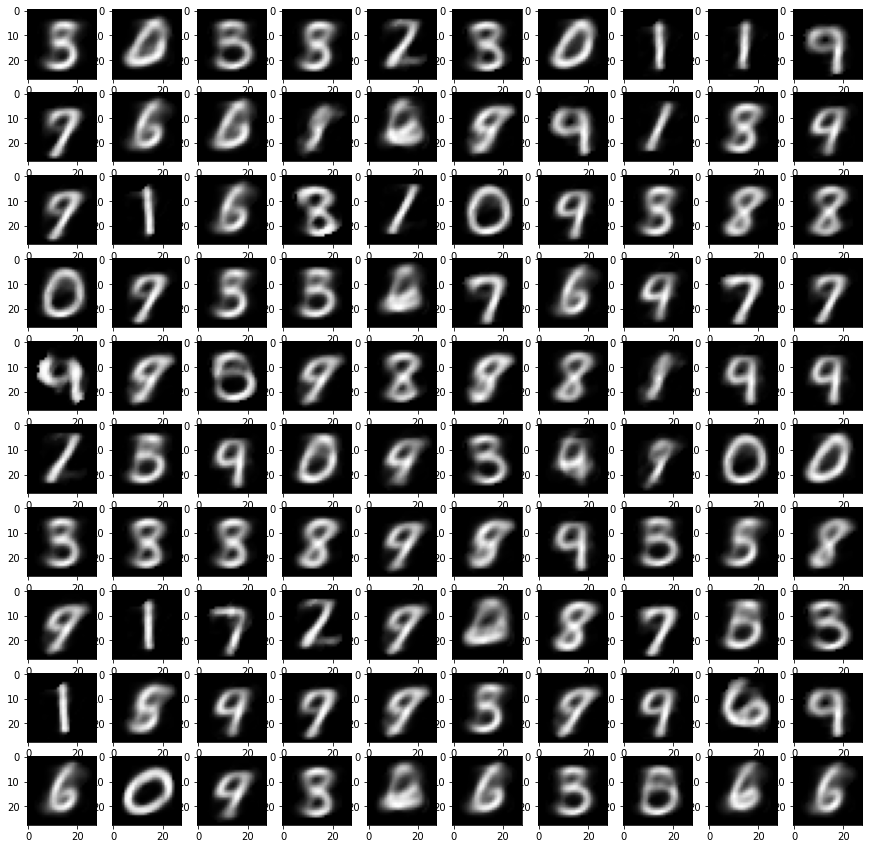

In [4]:
fig, axs = plt.subplots(10, 10, figsize=(15,15))
col_ctr, row_ctr = 0, 0
for i in range(100):
  axs[row_ctr, col_ctr].imshow(q3a_draws[i, :, :, 0] * 255, cmap='gray')
  col_ctr += 1
  if col_ctr == 10:
    row_ctr += 1
    col_ctr = 0

By and large, the results are pretty good! The reconstructed images are often a bit fuzzier -- occasionally to the point they're not a discernible number $\in [0, 9]$. But for the most part, the results mirror the original images, and are recognizable reconstructions of the true number. 

### Problem 3b: Visualize the manifold of digits
Since we have specifically chosen the latent space to be 2-dimensional, now you can easily visualize the learned latent manifold of digits:
- Using your pre-trained recognition networks, transform images from the test set to the latent space. Visualize the points in the latent space as a scatter plot, where colors of the points should correspond to the labels of the digits.
- From the previous point, determine the min and max values of $z_1$ and $z_2$. Create a $20 \times 20$ grid that corresponds to $(z_1, z_2)$ values between the min and max. For each $z = (z_1, z_2)$, generate and visualize digits using each of your trained models, and plot each set on a $20 \times 20$ tile grid.


First, we make the scatterplot on the latent space. Indeed, there are "clusters" corresponding to image numbers. 

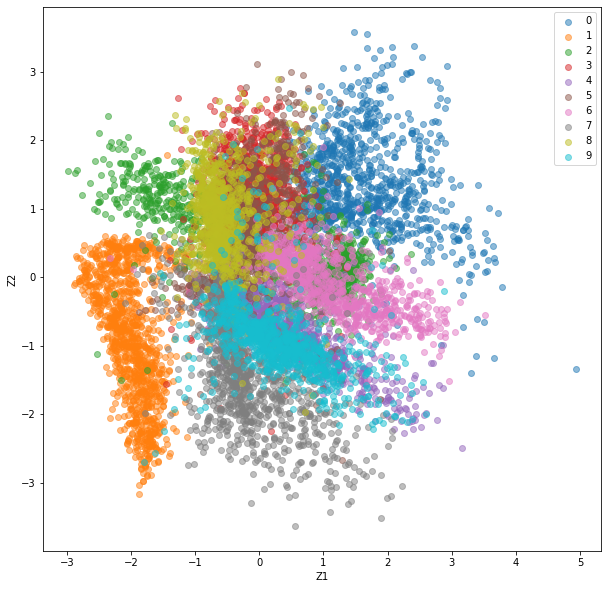

In [6]:
plt.rcParams["figure.figsize"] = (10, 10)

z_test = mod_vae.mod_encoder.predict(x_test)[0]
actual_numbers = np.array([str(i) for i in y_test])
for val in np.unique(actual_numbers):
  idx = np.where(actual_numbers == val)
  plt.scatter(z_test[idx, 0], z_test[idx, 1], label=val, alpha=.5)
plt.legend()
plt.xlabel('Z1')
plt.ylabel('Z2')
plt.show()

Second, we construct the 20x20 grid. Importantly, we see all numbers represented somewhere on the grid (generally in positions corresponding to the clusters above). In the areas "between" clusters, the numbers are smushed and fuzzier -- this makes sense, as the model is split on where to send the latent $\mu_n, \sigma_n$ in reconstructed form. 

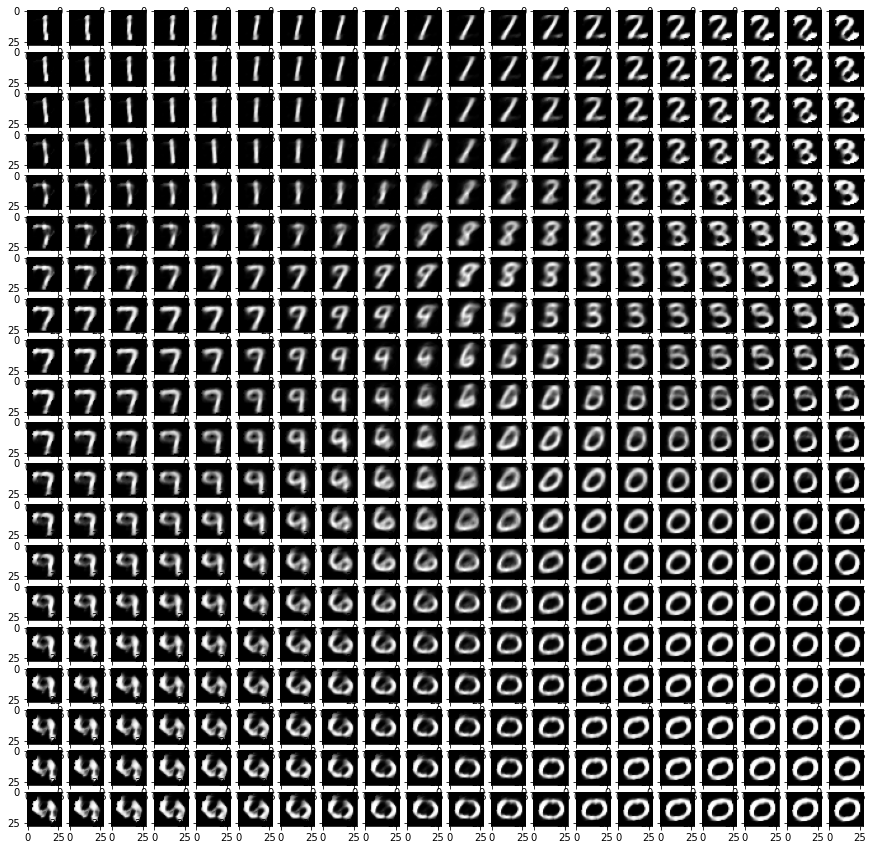

In [7]:
import itertools
z1_min, z1_max = np.min(z_test[:, 0]), np.max(z_test[:, 0])
z2_min, z2_max = np.min(z_test[:, 1]), np.max(z_test[:, 1])

z1_bins = np.linspace(z1_min, z1_max, 20)
z2_bins = np.linspace(z2_min, z2_max, 20)

fig, axs = plt.subplots(20, 20, figsize=(15, 15))
for i, j in itertools.product(range(20), range(20)):
  z1, z2 = z1_bins[i], z2_bins[j]
  xhat = mod_vae.mod_decoder.predict(np.array([z1, z2]).reshape(1, 2)).reshape((1, ) + mod_vae.img_dim)
  axs[i, j].imshow(xhat[0, :, :, 0] * 255, cmap='gray')
plt.show()

Importantly, we see all of the numbers 0-9 on this grid -- implying that the latent mapping can pick up any such number

## Problem 4: Discussion

### Problem 4a: Laplace prior on the latents
Suppose we instead used a [Laplace prior](https://en.wikipedia.org/wiki/Laplace_distribution) $z_n \sim \mathrm{Lap}(0, \tau)$ with density
\begin{align}
p(z_n) &= \frac{1}{2\tau}\exp \left\{-\frac{|z_n|}{\tau} \right\}.
\end{align}
Propose a simple reparametrization of the Laplace distribution $z_n = r(\epsilon_n, \tau)$ with $\epsilon_n \sim p(\epsilon)$ for some function $r$ and distribution $p$, suitable for training a VAE.


One obvious solution might be to use the CDF trick, commonly used in random number generation and elsewhere. Specifically, we this procedure would involve sampling
$$
\epsilon_n \sim U(0, 1),
$$
and then computing 
$$
z_n = F_{laplace(0, t)}^{-1}(\epsilon_n),
$$
where $F_{laplace(0, t)}^{-1}$ is the inverse CDF of the above Laplace distribution. In this case, we have that
$$
F_{laplace(0, t)}^{-1}(\epsilon_n)
=
-\tau \cdot sign(\epsilon_n - 1/2)\log(1 - 2|\epsilon_n - 1/2|)
$$
$$
\implies
$$
$$
\nabla_t F_{laplace(0, t)}^{-1}(\epsilon_n)
=
\frac{
  (2\epsilon_n - 1)\tau \cdot sign(\epsilon_n - 1/2)
}{(1 - 2|\epsilon_n - 1/2|)(|\epsilon_n - 1/2|)}.
$$
We would then draw samples $\epsilon_n \sim U(0, 1)$, plug them into the equation above, and average (as before) to get 
$$
E_{\epsilon_n \sim U(0, 1)}\bigg[
\nabla_t F_{laplace(0, t)}^{-1}(\epsilon_n)\bigg] = 
E_{\epsilon_n \sim U(0, 1)}\bigg[
\frac{
  (2\epsilon_n - 1)\tau \cdot sign(\epsilon_n - 1/2)
}{(1 - 2|\epsilon_n - 1/2|)(|\epsilon_n - 1/2|)}
\bigg]. 
$$
Again, we'd revert to the same general MC procedure as above. 

### Problem 4b: Discrete latent variables
The present model uses continuous latent variables. Where did we use this assumption and what would have to change if we used discrete $z_n$'s instead?

First, note that our neural nets wouldn't have to change too much. The final layer of the encoder would have to be changed so that it outputted a vector containing the one-hot-encoded/class probability/indicator components of $z_N$; this would be achieved by replacing the final layer with a sigmoid layer and/or multiple softmaxes outputs. Similarly, the input layer of the decoder would have to be reconfigured to take in these class probability/indicators, but the rest of the network could largely remain the same. 

However, the mechanics we used for inference would have to change considerably to accomodate this new distribution. Specifically, we would have to recompute:

- In the $\nabla_\phi$ step, the $D_{KL}(q(z_n;\lambda_n) || p(z_n))$, for which we had a closed form, would surely change with a discrete $z_n$. Our new KL-Divergence here might not be closed form. 

- Moreover, the assumption of normality in our variational assumption -- i.e. the $q(z_n;\lambda_n) \sim N(\cdot, \cdot)$, would likely change, as a normal distribution would no longer be an appropriate approximation to the true $p(z_n|-)$, given the fundamental structural differences here. This too would change the aforementioned KL-Divergence term, as not only would the latter term (the "to term") be non-normal/discrete, but the first term as well (the "from term").

So clearly, this kind of alteration would require substantial changes to our computation of the ELBO. However, that's not to say it's impossible -- there may be categorical distributions equally convenient to the normal that we can plug in here, giving us a similar amount of closed-form/analytical/"nice" as the normal. 

# Submission Instructions


**Formatting:** check that your code does not exceed 80 characters in line width. If you're working in Colab, you can set _Tools &rarr; Settings &rarr; Editor &rarr; Vertical ruler column_ to 80 to see when you've exceeded the limit. 

Download your notebook in .ipynb format and use the following commands to convert it to PDF:
```
jupyter nbconvert --to pdf hw6_yourname.ipynb
```

**Dependencies:**

- `nbconvert`: If you're using Anaconda for package management, 
```
conda install -c anaconda nbconvert
```

**Upload** your .ipynb and .pdf files to Gradescope. 
